# Learn HLA representation

`themap` learns representation of HLA alleles from [`IPD-IMGT/HLA database`](https://www.ebi.ac.uk/ipd/imgt/hla/). 

**Human Leukocyte Antigen (HLA)** (or Major Histocompatibility Complex, MHC) molecules are cell surface proteins that play a critical role in the immune system by presenting peptide fragments to T cells. These peptides, typically derived from endogenous or pathogenic proteins, are displayed in the binding groove of HLA molecules and scanned by T cell receptors (TCRs) to initiate immune responses.

HLA molecules are broadly categorized into **Class I** and **Class II**. Class I HLA molecules (e.g., **HLA-A, HLA-B, HLA-C**) present peptides derived from intracellular proteins—such as viral antigens or tumor-associated proteins—to CD8⁺ cytotoxic T cells. In contrast, Class II HLA molecules (e.g., HLA-DR, HLA-DP, HLA-DQ) present peptides originating from extracellular proteins to CD4⁺ helper T cells. This distinction reflects their specialized roles in monitoring different compartments of the immune landscape and orchestrating appropriate adaptive immune responses. **Our current algorithm focuses specifically on Class I HLA molecules and their peptide presentation**.

Each HLA allele encodes a slightly different protein sequence, which determines the peptide binding specificity. Although different HLA alleles may vary at the amino acid level, many share conserved motifs in their binding regions. **Amino acid sequence similarity between HLA alleles can lead to overlapping peptide repertoires, meaning that structurally similar HLAs may present similar peptides.** This has important implications in immune recognition, cross-reactivity, transplant compatibility, and vaccine design.


```{image} ../_static/HLA.png
:alt: 模型结果图
:width: 800px
:align: center

## Load HLA amino-acid sequences

There are two options to learn the representation:
1. considers **165** amino acid residues ([Download hla_dict_165.npy](https://drive.google.com/file/d/1BFrtlHt0MRkqsXtwA6qMrJ-cahf0jPh-/view?usp=drive_link))
2. consider **34** amino acid residues known to interact with peptides ([Download hla_dict_34.npy](https://drive.google.com/file/d/16X8CqaIOq6qbbA6zUW9-AGxzi5CUIcO_/view?usp=drive_link))

In our study, we use the 34 amino acid residues. We can use the `hla_dict_34.npy` file to load the HLA amino acid sequences. 
The file contains a dictionary where the keys are the HLA allele names and the values are the corresponding amino acid sequences. 

To reduce redundancy, alleles sharing identical first and second field designations were merged.

The code below demonstrates how to load this file and access the sequences for specific HLA alleles.

Load required libraries

In [1]:
import numpy as np
import torch
from themap import utils
from themap import model
import matplotlib.pyplot as plt

Fix ramdon seed to ensure reproducibility

In [2]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
hla_dict = np.load('hla_dict_34.npy', allow_pickle=True).item()
for k, v in list(hla_dict.items())[:10]:
    print(f"{k}: {v}")

A*01:01: YFAMYQENMGHTDANTLYIIYRDYTWVARVYRGY
A*01:02: YSAMYQENMGHTDANTLYIIYRDYTWVARVYRGY
A*01:03: YFAMYQENMGHTDANTLYIMYRDYTWVARVYRGY
A*01:04: YFAMYQENMGHTDANTLYIIYRDYTWVARVYRGY
A*01:06: YFAMYQENMGHTDANTLYIIYRDYTWVALAYRGY
A*01:07: YFAMYQENVGHTDENTLYIIYRDYTWVARVYRGY
A*01:08: YFAMYQENMGHTDANTLYIIYRDYTWVARVYWGY
A*01:09: YFAMYQENMGHTDANTLYIIYRDYTWVARVYRGY
A*01:10: YFAMYQENMGHTDANTLYIIYRDYTWARRVYRGY
A*01:100: YFAMYQENMGHTDANTLYIIYRDYTWVARVYRGY


In [4]:
print(hla_dict['B*27:05'])
print(hla_dict['B*27:04'])

YHTEYREICRKTDEDTLYLNYHDYTWAVLAYEWY
YHTEYREICRKTDESTLYLNYHDYTWAELAYEWY


## Encode HLA sequences with BLOSUM50 substitution matrix

Encode HLA sequences with BLOSUM50 substitution matrix, resulting in a 21x34 matrix for each HLA. It captures the biochemical features of each HLA allele in a fixed-length representation suitable for model input.

In [5]:
hla_aa = list(hla_dict.values())
hla_name = list(hla_dict.keys())
HLA_length = len(hla_aa[0])
HLA_lib_array = utils.amino_acid_encode(hla_aa, maxlen=HLA_length)
HLA_lib_tensor = torch.from_numpy(HLA_lib_array).transpose(1,2).float()
print(HLA_lib_tensor.shape)

torch.Size([10004, 21, 34])


Create a dataloader to load the HLA sequences. The dataloader will yield batches of data for training or evaluation.


In [6]:
hla_dataset = torch.utils.data.TensorDataset(HLA_lib_tensor)
hla_loader = torch.utils.data.DataLoader(hla_dataset, batch_size=256, shuffle=True)

## Train the model

Load model and choose the device (GPU or CPU) for training. 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hla_model = model.HLA_vae(input_size=[21, HLA_length], latent_size=256).to(device)
hla_model.train_model(hla_loader, epochs=200, lr=1e-4, device=device)
torch.save(hla_model.state_dict(), 'hla_model.pt')

Epochs: 100%|██████████| 200/200 [01:14<00:00,  2.67it/s, KL_loss=0.0148,recon_loss=0.3391]


Load our pre-trained model if needed. [Download hla_model.pt](https://drive.google.com/file/d/1ogPnFEfJMdcLLMj5Ky5E__57BeMEeqfG/view?usp=drive_link)

In [ ]:
hla_model.load_state_dict(torch.load('hla_model.pt'))

## Visualize the learned HLA representation

Visualize HLA embeddings using PCA with colors representing different HLA types (HLA-A, HLA-B, HLA-C).

torch.Size([10004])
HLA-A: 3177
HLA-C: 2912
HLA-B: 3915


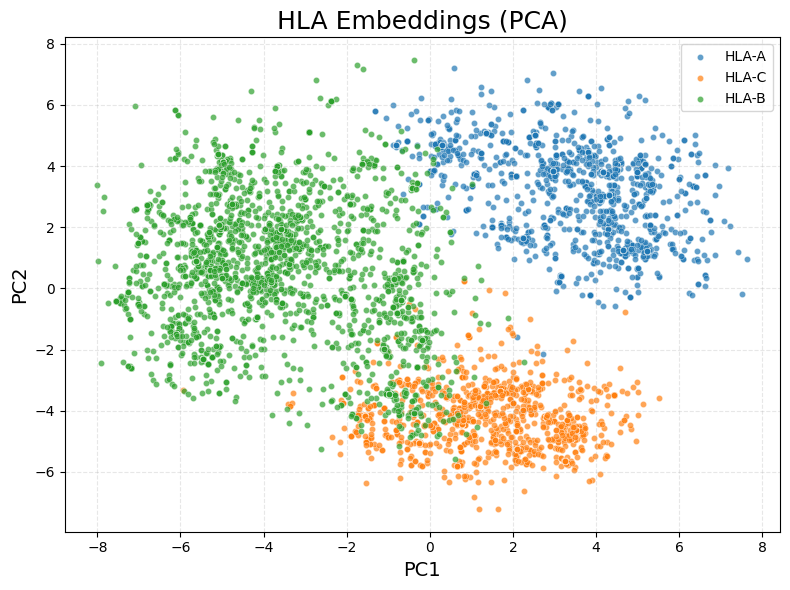

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

hla_name_allele = [x[:1] for x in hla_name]
hla_group = list(set(hla_name_allele))
hla_labels = torch.tensor([hla_group.index(element) for element in hla_name_allele]).long()
print(hla_labels.shape)

pca = PCA(n_components=2)
hla_test_loader = torch.utils.data.DataLoader(hla_dataset, batch_size=256, shuffle=False)
hla_lib_embed, _ = hla_model.embed_hla(hla_test_loader, device)
hla_lib_embed = pca.fit_transform(hla_lib_embed)

label_unique = np.unique(hla_labels)
cmap = plt.get_cmap("tab10") 

fig, ax = plt.subplots(figsize=(8, 6))

for i, label in enumerate(label_unique):
    ind = np.where(hla_labels == label)[0]
    print(f'HLA-{hla_group[label]}: {len(ind)}')
    ax.scatter(
        hla_lib_embed[ind, 0],
        hla_lib_embed[ind, 1],
        label='HLA-' + hla_group[label],
        s=20,
        alpha=0.7,
        color=cmap(i % 20),
        edgecolors='w',
        linewidths=0.3
    )

# 美化图像
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_title('HLA Embeddings (PCA)', fontsize=18)
ax.grid(True, linestyle='--', alpha=0.3)

ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()

## Highlight specific HLA alleles in the learned representation space

/tmp/ipykernel_1832073/3622903819.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20b", len(highlight_terms))


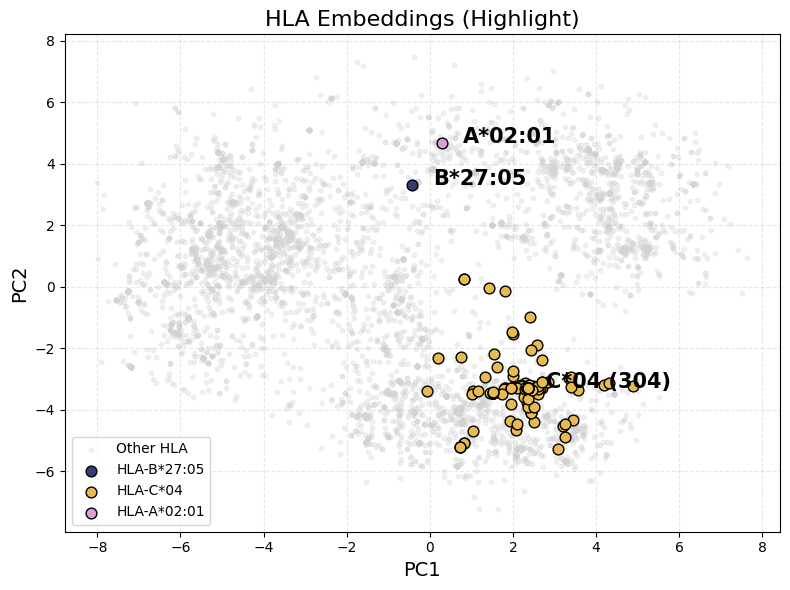

In [12]:
def highlight_hla_embeddings(hla_embed, hla_name, highlight_terms, figsize=(8, 6)):
    """
    Highlight specific HLA alleles in a 2D embedding space using distinct colors.
    
    Supports fuzzy matching (e.g., 'A*02' matches all 'A*02:xx'), and labels
    each group once at the centroid. Each term is colored differently.

    Parameters:
    - hla_embed: np.ndarray of shape [n_samples, 2]
    - hla_name: list of str, allele names per point
    - highlight_terms: list of str, allele names or prefixes to highlight
    - figsize: tuple, size of figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm

    fig, ax = plt.subplots(figsize=figsize)

    # Background: all points in light gray
    ax.scatter(
        hla_embed[:, 0],
        hla_embed[:, 1],
        color='lightgray',
        s=10,
        alpha=0.3,
        label='Other HLA',
        zorder=1
    )

    # Create a color map for unique colors
    cmap = cm.get_cmap("tab20b", len(highlight_terms))
    used_labels = set()

    for idx, term in enumerate(highlight_terms):
        matched = [(i, name) for i, name in enumerate(hla_name) if name.startswith(term)]
        if not matched:
            print(f"No HLA matched for: {term}")
            continue

        indices = [i for i, _ in matched]
        xs, ys = hla_embed[indices, 0], hla_embed[indices, 1]

        # Use a distinct color per term
        color = cmap(idx)

        ax.scatter(
            xs, ys,
            color=color,
            edgecolors='black',
            s=60,
            zorder=5,
            label=f'HLA-{term}' if term not in used_labels else None
        )

        used_labels.add(term)

        # Add a label once at the centroid of the group
        if len(matched) == 1:
            term = matched[0][1]
        elif len(matched) > 1:
            term = f"{term} ({len(matched)})"
        else:
            term = matched[0][1]
        center_x, center_y = np.mean(xs), np.mean(ys)
        ax.text(center_x + 0.5, center_y, term, fontsize=15, fontweight='bold', color='black', zorder=6)

    ax.set_title('HLA Embeddings (Highlight)', fontsize=16)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.show()

# Highlight specific HLA alleles
highlight_alleles = ['B*27:05', 'C*04', 'A*02:01']
highlight_hla_embeddings(hla_lib_embed, hla_name, highlight_alleles)